<br><br>

<center><u><font size="5" color="blue">Final Presentation : Cholesky Decomposition and Monte Carlo- Team MBA 50s</font></u></center>



<br>

### Table of Contents

* [Steps](#steps)
* [QuantPy](#quantpy)
* [Linear Algebra Review](#review)
* [Step by Step](#demonstration)
* [Monte Carlo Simulation](#mc)  
    
<br>

<pre>

    The Cholesky decomposition is commonly used in the Monte Carlo method for simulating systems with multiple correlated variables.  It is appropriate when dealing with a multi-variate normalized distribution as we assume we are.
    
    
</pre>

<br><br>

<center><font size="5" color="blue"><u>Steps</u></font></center><a class="anchor" id="steps"></a>

<br><br>


1. Create a covariance matrix based on the price history of each instrument.

2. Perform Cholesky decomposition on that matrix to create a Lower Triangular matrix.

3. Create a schotastic parameter with the inner product of above and a random sampling of normal standard deviations.

4. Apply the schotastic parameter to the average change of each instrument.

5. Finally qualify that by the weight of each instrument and by the initial market value.

6. Use cumsum to get the final percent change and final market value.

<br><br>



<br><br>

<center><font size="5" color="blue"><u>QuantPy</u></font></center><a class="anchor" id="quantpy"></a>

<br><br>



<br><br>

The inspiration for this presentation comes from this [QuantPy](https://www.youtube.com/watch?v=6-dhdMDiYWQ&list=PLqpCwow11-OqqfELduCMcRI6wcnoM3GAZ) presentation. 


<br>

The source code in this presentation is only slightly modified, so the true source is here [here](https://quantpy.com.au/monte-carlo/monte-carlo-as-a-tool-for-financial-math/)

<br>

Note all of our functions are using numpy. I mention this because dataframes and numpy arrays often behave differently
when accessing, printing, formatting, etc..

<br>

We will make use of the following numpy functions : `linalg.cholesky, inner, full and cumprod.`

<br>


The last time we used Monte Carlo on our portfolio we used the pandas_montecarlo package which leveraged
pandas dataframe inheritence methodology to process the history into a random sampling.

<br>

Specifically it called `series.sample(frac=1).values` to produce a series of random price changes that result
in the same end value, but the paths were randomly distributed.


<br><br>


<br><br><br><br>


<hr>

<br><br>

<center><font size="5" color="blue"><u>Linear Algebra Review</u></font></center><a class="anchor" id="review"></a>

<br><br>

<br>

<hr>


<br>


<br>

<b>Gaussian Elimination</b>

<pre>
         Use a sequence of elementary row operations to modify the matrix until the lower left-hand corner
         of the matrix is filled with zeros. Eliminate rows that do not contribute to solving the linear equatiosn.
         The three types of elementary row operations are:

            1) Swapping two rows
            2) Multiplying a row by a nonzero number
            3) Adding a multiple of one row to another row
            
</pre>


<br>

<b>LDU Decomposition</b>

<pre>
        Factors out a square matrix into a lower, upper and diagonal components.
            
</pre>

In [383]:
from scipy.linalg import lu
import numpy as np

A_ex = np.array([[2, 5, 8, 7], [5, 2, 2, 8], [7, 5, 6, 6], [5, 4, 4, 8]])
D_ex, L_ex, U_ex = lu(A_ex)

print('\n' * 4)
print("               Matrix A_ex ")
print("               ----------- ")
print("")
for a in A_ex:
    print("{:>10.2f} {:>10.2f}  {:>10.2f} {:>10.2f}".format(*a,))

  
print('\n' * 4)
print("               Matrix L_ex ")
print("               ----------- ")
print("")
for a in L_ex:
    print("{:>10.2f} {:>10.2f}  {:>10.2f} {:>10.2f}".format(*a,))

print('\n' * 4)
print("               Matrix U_ex ")
print("               ----------- ")
print("")
for a in U_ex:
    print("{:>10.2f} {:>10.2f}  {:>10.2f} {:>10.2f}".format(*a,))

print('\n' * 4)

# prove they are factors
# note @ is the matrix dot product operator, this is the same as    np.dot(D_ex,np.dot(L_ex,U_ex))
proof_ex = D_ex @ L_ex @ U_ex

print("               Matrix D_ex @ L_ex @ U_ex ")
print("               --------------------------")
print("")
for a in proof_ex:
    print("{:>10.2f} {:>10.2f}  {:>10.2f} {:>10.2f}".format(*a,))
    
print("")   

print("Note the shape of these matrices are all ", U_ex.shape)

print('\n' * 4)






               Matrix A_ex 
               ----------- 

      2.00       5.00        8.00       7.00
      5.00       2.00        2.00       8.00
      7.00       5.00        6.00       6.00
      5.00       4.00        4.00       8.00





               Matrix L_ex 
               ----------- 

      1.00       0.00        0.00       0.00
      0.29       1.00        0.00       0.00
      0.71       0.12        1.00       0.00
      0.71      -0.44       -0.46       1.00





               Matrix U_ex 
               ----------- 

      7.00       5.00        6.00       6.00
      0.00       3.57        6.29       5.29
      0.00       0.00       -1.04       3.08
      0.00       0.00        0.00       7.46





               Matrix D_ex @ L_ex @ U_ex 
               --------------------------

      2.00       5.00        8.00       7.00
      5.00       2.00        2.00       8.00
      7.00       5.00        6.00       6.00
      5.00       4.00        4.00       8.00

Not

<br>

However Monte Carlo is better served by using the Cholesky decomposition which is computationally more efficient.

<br>

Not every matrix can be decomposed using Cholesky. The matrix needs to be a <b><i>positive definite</i></b> matrix.

<br>

That is it should be of the form

<br>

$$A = A^T$$

<br>

and the lower trianglulation will reveal

<br>

$$A= L * L^T$$

<br>

Fortunately a covariance matrix by definition is a <b><i>positive definite</i></b> matrix.

<br>


<br><br><br><br>


<hr>

<br><br>

<center><font size="5" color="blue"><u>Step by Step Demonstration</u></font></center><a class="anchor" id="demonstration"></a>

<br><br>

<br>

<hr>


<br>

We will apply the math just once on 3 instruments to gain some understanding on how Cholesky decomposition works and how the schochastic application is done. Then well run Monte Carlo.

<br>

In [299]:

tickers = ['GOOG', 'IBM', 'ADP']

T = 100 # of days in the future we are simulating

<br>

Import libraries. Create the function to download the price history and create the covariance matrix.

<br>

Note we are using the series `pct_change()` function to translate daily prices to daily price changes.

<br>

In [300]:
import pandas as pd
import datetime
import matplotlib.pyplot as plt
from pandas_datareader import data as pdr


# import data
def get_data(stocks, start, end):
    stockData = pdr.get_data_yahoo(stocks, start, end)
    stockData = stockData['Close']
    returns = stockData.pct_change()
    meanReturns = returns.mean()
    covMatrix = returns.cov()
    closePrices = stockData[-1:]
    return closePrices, meanReturns, covMatrix


# stocks = [stock for stock in tickers]

endDate = datetime.datetime.now()
startDate = endDate - datetime.timedelta(days=300)

closePrices, meanReturns, covMatrix = get_data(tickers, startDate, endDate)

<br>

Recall a covariance matrix indicates how much each instrument varies from another instrument. The diagonal
represents the variance of that instrument.

<br>

Below we are demonstrating that covariance matrix A and lower triangulation L have the aforementioned properties suitable so we know our Choleskly matrix is good.

<br>

In [304]:
A=np.array(covMatrix)
L = np.linalg.cholesky(covMatrix)  



print('\n' * 4)
print("          Covariance Matrix A ")
print("          ------------------- ")
print("")
for a in A:
    print("{:>10.5f} {:>10.5f}  {:>10.5f}".format(*a,))

  
print('\n' * 4)
print("               Matrix L ")
print("               -------- ")
print("")
for a in L:
    print("{:>10.5f} {:>10.5f}  {:>10.5f}".format(*a,))

B=L.dot(L.T)
    
print('\n' * 4)
print("               Matrix L * L.T ")
print("               -------------- ")
print("")
for a in B:
    print("{:>10.5f} {:>10.5f}  {:>10.5f}".format(*a,))

print('\n' * 4)

print("Note the shape of all these matrices is ", A.shape)

print('\n' * 4)







          Covariance Matrix A 
          ------------------- 

   0.00064    0.00016     0.00030
   0.00016    0.00023     0.00013
   0.00030    0.00013     0.00029





               Matrix L 
               -------- 

   0.02525    0.00000     0.00000
   0.00616    0.01398     0.00000
   0.01184    0.00431     0.01158





               Matrix L * L.T 
               -------------- 

   0.00064    0.00016     0.00030
   0.00016    0.00023     0.00013
   0.00030    0.00013     0.00029





Note the shape of all these matrices is  (3, 3)







<br>

Next we create a matrix of random Z scores, that is deviatons from a mean. This is our schocastic component.

<br>

In [305]:
Z = np.random.normal(size=(T, len(tickers)))

print('\n' * 4)
print("                Matrix Z (Random Z-Scores) ")
print("                -------------------------- ")
print("")

for a in Z[0:5]:
    print("{:>12,.5f} {:>12,.5f} {:>12,.5f}  ".format(*a))

print("{:>12} {:>12} {:>12}  ".format('...','...','...'))   
print('\n' * 4)

print("Note the shape of matrix Z is ", Z.shape)

print('\n' * 4)







                Matrix Z (Random Z-Scores) 
                -------------------------- 

     1.82409     -0.34306     -2.63616  
    -0.06165      0.33819      1.76569  
     0.38437     -2.96332     -0.39608  
     0.22422      0.02639      0.07903  
    -1.54040     -2.11387      1.05484  
         ...          ...          ...  





Note the shape of matrix Z is  (100, 3)







<br>

Next we create an inner matrix of L and Z. The result is a combination of covariance + random deviations.

<br>

In [306]:
I = np.inner(L, Z) 

print('\n' * 4)

print("                Matrix I (Random ZScores + Covariance) ")
print("                -------------------------------------- ")
print("")

for a in I:
    print("{:>12,.5f} {:>12,.5f} {:>12,.5f} {:>12,.5f} {:>12,.5f} ... ".format(*a))
    
print('\n' * 4)

print("Note the shape of matrix I is ", I.shape)

print('\n' * 4)







                Matrix I (Random ZScores + Covariance) 
                -------------------------------------- 

     0.04606     -0.00156      0.00971      0.00566     -0.03890 ... 
     0.00645      0.00435     -0.03906      0.00175     -0.03905 ... 
    -0.01040      0.02117     -0.01281      0.00368     -0.01514 ... 





Note the shape of matrix I is  (3, 100)







<br>

Next we allocate the total value of each instrument into a total of 100%. This <i>weights</i> our results.

<br>

In [318]:
adp_mv=5200 * closePrices['ADP'][0]
goog_mv=1000 * closePrices['GOOG'][0]
ibm_mv=2500 * closePrices['IBM'][0]
weights = [adp_mv, goog_mv, ibm_mv]

initial_mv = sum(weights)

print('\n' * 4)

print("Individual Market Values (weights) =     {:>10,.0f} {:>10,.0f} {:>10,.0f}".format(*weights), sep='\n')
print("Initial Portfolio Market Value =         {:>10,.0f}".format(initial_mv))

weights /= np.sum(weights)         # scale them so they add up to 1

print("Weight Allocations =                     {:>9.0f}% {:>9.0f}% {:>9.0f}%".format(*weights*100))

print('\n' * 4)






Individual Market Values (weights) =      1,372,540     97,600    370,925
Initial Portfolio Market Value =          1,841,065
Weight Allocations =                            75%         5%        20%







<br>

Next we create a matrix of the mean return of each instrument. The same value is placed for every day of our simulation...


<br>

In [309]:
print('\n' * 4)

M = np.full(shape=(T, len(tickers)), fill_value=meanReturns)
M = M.T


print('\n' * 4)

print("      Matrix M ")
print("     --------------- ")
print("")

for a in M:
    print("{:>12,.5f} {:>12,.5f} {:>12,.5f} {:>12,.5f} {:>12,.5f} ... ".format(*a))
    
print('\n' * 4)


print("Note the shape of matrix M is ", M.shape)

print('\n' * 4)













      Matrix M 
     --------------- 

    -0.00127     -0.00127     -0.00127     -0.00127     -0.00127 ... 
     0.00062      0.00062      0.00062      0.00062      0.00062 ... 
     0.00134      0.00134      0.00134      0.00134      0.00134 ... 





Note the shape of matrix M is  (3, 100)







<br>

Next we create simulated daily return for all instruments by adding I to the mean

<br>

In [310]:
DR = M + I


print('\n' * 4)

print("      Matrix DR (Mean Return + Inner (ZScore * Covariance) ")
print("     ----------------------------------------------------- ")
print("")

for a in DR:
    print("{:>12,.5f} {:>12,.5f} {:>12,.5f} {:>12,.5f} {:>12,.5f} ... ".format(*a))

    
print('\n' * 4)


print("Note the shape of DR is ", DR.shape)

print('\n' * 4)






      Matrix DR (Mean Return + Inner (ZScore * Covariance) 
     ----------------------------------------------------- 

     0.04479     -0.00283      0.00843      0.00439     -0.04017 ... 
     0.00707      0.00497     -0.03843      0.00237     -0.03842 ... 
    -0.00906      0.02251     -0.01147      0.00502     -0.01380 ... 





Note the shape of DR is  (3, 100)







<br>

Finally we aggregate each daily return and multiply it by the initial portfolio market value.

<br>

In [322]:
daily_mvs = np.cumprod(np.inner(weights, DR.T)+1)*initial_mv

print("\nNote the shape of daily_mvs is ", daily_mvs.shape, end='\n\n\n')

for a in daily_mvs[0:5]:
    print("{:<10,.0f}  ".format(a))

print("...")

for a in daily_mvs[95:]:
    print("{:<10,.0f}  ".format(a))
    

print("Initial Portfolio Market Value =                          {:>10,.0f}".format(initial_mv))
print("\nFinal Portfolio Market Value after ", T, " days is           {:<10,.0f} \n".format(daily_mvs[-1,]) )


Note the shape of daily_mvs is  (100,)


1,899,871   
1,904,980   
1,908,675   
1,917,092   
1,850,442   
...
1,833,294   
1,803,566   
1,860,126   
1,854,726   
1,868,660   
Initial Portfolio Market Value =                           1,841,065

Final Portfolio Market Value after  100  days is           1,868,660  



<br><br><br><br>


<hr>

<br><br>

<center><font size="5" color="blue"><u>Prepare Monte Carlo</u></font></center><a class="anchor" id="mc"></a>

<br><br>

<br>

<hr>


In [357]:
path=r'C:\Users\arono\source\python\DATA618\Portfolio'
file='Portfolio.xlsx'
path_and_file=path + "\\" + file
portfolio_df = pd.read_excel(path_and_file)

In [358]:
portfolio_df.insert(9, "Price", 0.0, True)
portfolio_df.insert(10, "MarketValue", 0.0, True)
portfolio_df = portfolio_df.loc[(portfolio_df['Ticker'] !='CP') & (portfolio_df['Ticker'] !='Cash')]
portfolio_df = portfolio_df.set_index(portfolio_df.Ticker)
portfolio_df

,Ticker,Description,Asset Class,Asset Sub Class,EcoRisk,IRRisk,MarketHedge,InflationHedge,Shares,Price,MarketValue
Ticker,,,,,,,,,,,
MUB,MUB,iShares National Muni Bond ETF,Fixed Income,Municipal Bond,N,Y,N,N,2500,0.0,0.0
ADP,ADP,Automatic Data Processing,Equities,Equity Industry,N,N,N,N,5200,0.0,0.0
GOOG,GOOG,Alphabet Inc.,Equities,Equity Tech,Y,N,N,N,1000,0.0,0.0
IBM,IBM,International Business Machines,Equities,Equity Tech,Y,N,N,N,2500,0.0,0.0
TLT,TLT,iShares 20+ Year Treasury Bond ETF,Fixed Income,Treasury Bond,N,Y,N,N,6000,0.0,0.0
MTGP,MTGP,WisdomTree Mortgage Plus Bond Fund,Fixed Income,Mortgage Bond,Y,Y,N,N,1500,0.0,0.0
NETL,NETL,NETLease Corporate Real Estate ETF,Real Estate,Real Estate,Y,Y,N,N,10000,0.0,0.0
NUGO,NUGO,Nuveen Growth Opportunities ETF,Equities,Equity Growth,Y,N,N,N,4000,0.0,0.0
NUHY,NUHY,Nuveen ESG High Yield Corporate Bond ETF,Fixed Income,Corporate Bond,Y,N,N,N,2500,0.0,0.0


In [359]:
tickers=portfolio_df['Ticker']
closePrices, meanReturns, covMatrix = get_data(tickers, startDate, endDate)

In [360]:
# calculate the current and total market values

for ticker in tickers:
    shares=portfolio_df.loc[ticker,'Shares']
    price=closePrices[ticker][0]
    portfolio_df.loc[ticker,'Price']=price
    portfolio_df.loc[ticker,'MarketValue']=shares*price


    # note MarketValue.sum() excludes Cash and CP
tot_mv_initial=portfolio_df.MarketValue.sum()
tot_mv_initial_str="${:,.0f}".format(total_market_value)
print("Total Initial portfolio value ", tot_mv_initial_str)
    
    
for ticker in tickers: 
        market_value=portfolio_df.loc[ticker,'MarketValue']
        portfolio_df.loc[ticker,'Allocation']=market_value/tot_mv_initial

weights=portfolio_df['Allocation']
portfolio_df[['Ticker','Shares','MarketValue', 'Price', 'Allocation']]

Total Initial portfolio value  $81,617,244


,Ticker,Shares,MarketValue,Price,Allocation
Ticker,,,,,
MUB,MUB,2500,2.636250e+05,105.449997,0.051098
ADP,ADP,5200,1.372540e+06,263.950012,0.266035
GOOG,GOOG,1000,9.760000e+04,97.599998,0.018917
IBM,IBM,2500,3.709250e+05,148.369995,0.071895
TLT,TLT,6000,6.174000e+05,102.900002,0.119669
MTGP,MTGP,1500,6.555000e+04,43.700001,0.012705
NETL,NETL,10000,2.628000e+05,26.280001,0.050938
NUGO,NUGO,4000,7.380000e+04,18.450001,0.014304
NUHY,NUHY,2500,5.167250e+04,20.669001,0.010016



<hr>

<br><br>

<center><font size="5" color="blue"><u>Run Monte Carlo</u></font></center><a class="anchor" id="mc"></a>

<br><br>

<hr>

In [361]:
mc_sims=5000
portfolio_sims = np.full(shape=(T, mc_sims), fill_value=0.0)

for m in range(0, mc_sims):
    L = np.linalg.cholesky(covMatrix) 
    Z = np.random.normal(size=(T, len(tickers)))
    I = np.inner(L, Z) 
    M = np.full(shape=(T, len(tickers)), fill_value=meanReturns)
    M = M.T
    DR = M + I
    daily_mvs = np.cumprod(np.inner(weights, DR.T)+1)*tot_mv_initial
    portfolio_sims[:,m] = daily_mvs/1000000


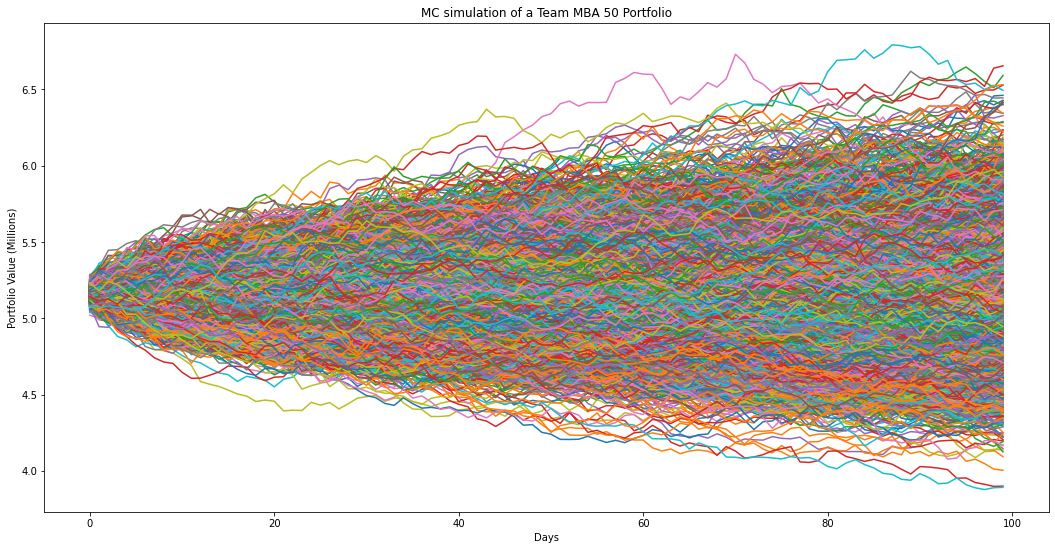

In [362]:
plt.figure(figsize=(18, 9))  
plt.plot(portfolio_sims)
plt.ylabel('Portfolio Value (Millions)')
plt.xlabel('Days')
plt.title('MC simulation of a Team MBA 50 Portfolio')
plt.show()


In [382]:
# to do format and multiply by 1MM

portResults=portfolio_sims[-1,:]
portResults=portResults * 1000000

port_max =  np.max(portResults)
port_min =  np.min(portResults)
port_var = np.percentile(portResults,5)
var = tot_mv_initial - port_var

# conditional var is the average of all results less than alpha
port_cvar = np.mean(portResults[portResults<port_var])
cvar = tot_mv_initial - port_cvar

print("Best result         = {:>10,.0f}".format(port_max))
print("Worst result        = {:>10,.0f}".format(port_min))      

print("\nPort VAR (95% CI)   = {:>10,.0f} ".format(port_var)) 
print("Port CVAR (95% CI)  = {:>10,.0f} ".format(port_cvar)) 

print("\nVAR (95% CI)        = {:>10,.0f} ".format(var)) 
print("CVAR (95% CI)       = {:>10,.0f} ".format(cvar)) 


Best result         =  6,653,188
Worst result        =  3,891,929

Port VAR (95% CI)   =  4,571,490 
Port CVAR (95% CI)  =  4,446,269 

VAR (95% CI)        =    587,754 
CVAR (95% CI)       =    712,976 
